# LunarLander-v3 Project using DQN and PPO

### Introduction

This notebook documents the development and analysis of a mini-project in Deep Reinforcement Learning (DRL), where two major algorithmic families — value-based methods (Deep Q-Network, DQN) and policy-based methods (Proximal Policy Optimization, PPO) — are trained and compared on the LunarLander-v3 environment from Gymnasium.

The main objective of this project is not only to obtain high-performing agents, but also to understand, analyse, and compare the learning dynamics of these two approaches under controlled experimental conditions. In particular, the project aims to:

Apply core concepts of Deep Reinforcement Learning in a realistic control environment.

Compare sample efficiency, stability, and final performance of DQN and PPO.

Analyse how different design choices (exploration strategy, policy/value approximation, clipping, etc.) influence learning behaviour.

Relate empirical observations to the theoretical foundations of RL, including:

value-based vs policy-based learning,

exploration–exploitation trade-offs,

reward shaping and credit assignment,

stability issues in Deep RL.

This notebook is structured in multiple phases. The current section corresponds to Phase A — Understanding the Environment, whose goal is to carefully analyse the LunarLander-v3 task before any learning algorithm is applied. This step is crucial to interpret later results and justify modelling choices.

🔹 Phase A — Environment Analysis (LunarLander-v3)

### Objective

Before training any agent, it is essential to understand the environment dynamics, state representation, action space, reward structure, and termination conditions. This phase provides a conceptual and empirical description of the LunarLander-v3 environment, forming the basis for later algorithmic comparisons.

This analysis also connects directly to theoretical topics discussed in class, namely:

Reward shaping and how dense vs. sparse rewards influence learning.

Credit assignment, i.e., how early actions contribute to delayed outcomes.

The impact of environment design on learning stability and sample efficiency.

 - Environment Overview

LunarLander-v3 is a classic control task in which an agent controls a lunar module that must land safely between two flags on a rough terrain. The problem combines elements of:

continuous state spaces,

discrete control actions,

delayed rewards,

and safety-critical behaviour (crash vs. soft landing).

The environment is considered solved when the agent achieves an average reward of at least 200 over 100 consecutive episodes.

# 1. Libraries

In [1]:
# ====== Libraries  ======
import os
import random
import numpy as np

import gymnasium as gym

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# DQN 
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor


from collections import deque, namedtuple
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from IPython.display import Image, display


In [2]:
# Reproducibility (basic)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Gymnasium version:", gym.__version__)

Gymnasium version: 1.2.3


## 2. Create LunarLander-v3 environment

In [3]:
# ====== Create LunarLander-v3 environment (random exploration) ======
ENV_ID = "LunarLander-v3"

env = gym.make(ENV_ID)  # no render for now (faster)
obs, info = env.reset(seed=SEED)
env.action_space.seed(SEED)

print("Env:", ENV_ID)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Initial obs shape:", obs.shape)
print("Initial obs:", obs)


Env: LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial obs shape: (8,)
Initial obs: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


## 2.1 First test with no RL 

In [4]:
# ====== Phase A: Random episodes inspection ======

def run_random_episodes(env_id="LunarLander-v3", n_episodes=100, seed=42, max_steps=2000):
    env = gym.make(env_id)
    env.action_space.seed(seed)

    ep_returns = []
    ep_lengths = []
    term_counts = {"terminated": 0, "truncated": 0}
    first_steps_obs = []   # store first obs of each episode
    last_steps_info = []   # store last step info

    for ep in range(n_episodes):
        obs, info = env.reset(seed=seed + ep)
        total_r = 0.0
        steps = 0
        first_steps_obs.append(obs.copy())

        for t in range(max_steps):
            a = env.action_space.sample()
            obs, r, terminated, truncated, info = env.step(a)
            total_r += float(r)
            steps += 1

            if terminated or truncated:
                if terminated:
                    term_counts["terminated"] += 1
                if truncated:
                    term_counts["truncated"] += 1
                last_steps_info.append({"episode": ep, "steps": steps, "terminated": terminated, "truncated": truncated})
                break

        ep_returns.append(total_r)
        ep_lengths.append(steps)

    env.close()

    ep_returns = np.array(ep_returns, dtype=float)
    ep_lengths = np.array(ep_lengths, dtype=int)

    summary = {
        "n_episodes": n_episodes,
        "return_mean": ep_returns.mean(),
        "return_std": ep_returns.std(ddof=1) if n_episodes > 1 else 0.0,
        "return_min": ep_returns.min(),
        "return_max": ep_returns.max(),
        "len_mean": ep_lengths.mean(),
        "len_std": ep_lengths.std(ddof=1) if n_episodes > 1 else 0.0,
        "len_min": ep_lengths.min(),
        "len_max": ep_lengths.max(),
        "term_counts": term_counts,
        "first_obs_examples": np.array(first_steps_obs),
        "last_steps_info": last_steps_info,
    }
    return summary, ep_returns, ep_lengths

summary, ep_returns, ep_lengths = run_random_episodes(n_episodes=100, seed=SEED)

print("=== Random policy (100 episodes) ===")
print("Return  mean±std:", round(summary["return_mean"], 2), "±", round(summary["return_std"], 2))
print("Return  min/max:", round(summary["return_min"], 2), "/", round(summary["return_max"], 2))
print("Length  mean±std:", round(summary["len_mean"], 2), "±", round(summary["len_std"], 2))
print("Length  min/max:", int(summary["len_min"]), "/", int(summary["len_max"]))

tc = summary["term_counts"]
n = summary["n_episodes"]
print("Terminations:", tc, "| terminated %:", round(100*tc["terminated"]/n, 1), "| truncated %:", round(100*tc["truncated"]/n, 1))

# quick look at distribution (text)
print("\nReturns (first 10):", np.round(ep_returns[:10], 2))
print("Lengths (first 10):", ep_lengths[:10])


=== Random policy (100 episodes) ===
Return  mean±std: -174.82 ± 103.25
Return  min/max: -461.57 / 22.32
Length  mean±std: 89.54 ± 20.07
Length  min/max: 61 / 169
Terminations: {'terminated': 100, 'truncated': 0} | terminated %: 100.0 | truncated %: 0.0

Returns (first 10): [-351.16 -139.51 -190.39 -258.03 -100.3  -242.65 -133.57 -283.55  -79.64
 -140.13]
Lengths (first 10): [123  78 115  88  61 106  74 134  69 116]


To obtain a robust empirical characterisation of the LunarLander-v3 environment, 100 episodes with a random policy were executed. The agent achieved a strongly negative average return (−174.82 ± 103.25), with all episodes terminating due to failure conditions rather than time truncation. This confirms that random behaviour almost always leads to crashes and highly sub-optimal trajectories.

The large variance in returns highlights the sensitivity of the environment to action sequences, where small differences in thrust decisions can significantly affect outcomes. Episode lengths varied substantially, reflecting different failure modes such as early crashes or unstable hovering before impact.

These results reinforce the theoretical insights discussed in the course. Despite the presence of reward shaping, successful performance requires a long sequence of coordinated actions, making the task sensitive to long-horizon credit assignment. Moreover, the consistently poor performance of random policies underlines the necessity of structured exploration strategies, such as ε-greedy exploration in DQN and entropy-regularised policy updates in PPO.

The LunarLander-v3 constitutes a non-trivial, safety-critical control task, providing a suitable benchmark to compare value-based and policy-based Deep Reinforcement Learning algorithms in subsequent experimental phases.

## 2.2 DQN test

In [5]:
OUT_DIR = "runs_lunarlander/"
os.makedirs(OUT_DIR, exist_ok=True)

def make_env(seed: int):
    def _init():
        env = gym.make(ENV_ID)
        env.reset(seed=seed)
        env.action_space.seed(seed)
        return env
    return _init

print("Ready. Next cell: DQN baseline train (1 seed).")

Ready. Next cell: DQN baseline train (1 seed).


In [6]:
# ====== Phase B — DQN baseline (1 seed) with simple logging ======
class SimpleDQNCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.ep_returns = []
        self.ep_lengths = []
        self.epsilons = []
        self.update_steps = []
        self._cur_return = 0.0
        self._cur_len = 0

    def _on_step(self) -> bool:
        # exploration rate (epsilon)
        if hasattr(self.model, "exploration_rate"):
            self.epsilons.append(float(self.model.exploration_rate))
        # gradient updates counter
        if hasattr(self.model, "_n_updates"):
            self.update_steps.append(int(self.model._n_updates))

        r = float(self.locals["rewards"][0])
        done = bool(self.locals["dones"][0])

        self._cur_return += r
        self._cur_len += 1

        if done:
            self.ep_returns.append(self._cur_return)
            self.ep_lengths.append(self._cur_len)
            self._cur_return = 0.0
            self._cur_len = 0

        return True

seed = SEED

train_env = DummyVecEnv([make_env(seed)])
eval_env  = gym.make(ENV_ID)

dqn = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=1e-4,
    buffer_size=100_000,
    learning_starts=10_000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=10_000,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    verbose=1,
    seed=seed,
)

cb = SimpleDQNCallback()

TOTAL_STEPS = 300_000  # baseline budget (we'll reuse same for PPO later)
dqn.learn(total_timesteps=TOTAL_STEPS, callback=cb, progress_bar=True)

# Deterministic evaluation (per project spec later we'll use 20 eps + 3 seeds)
mean_r, std_r = evaluate_policy(dqn, eval_env, n_eval_episodes=20, deterministic=True)

print("\n=== DQN baseline (1 seed) ===")
print("Train episodes logged:", len(cb.ep_returns))
print("Eval (20 eps) mean±std:", round(mean_r, 2), "±", round(std_r, 2))
print("Gradient updates (last):", cb.update_steps[-1] if cb.update_steps else None)

# Save model
model_path = os.path.join(OUT_DIR, f"dqn_baseline_seed{seed}.zip")
dqn.save(model_path)
print("Saved:", model_path)

eval_env.close()
train_env.close()


Using cpu device


c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 15268    |
|    time_elapsed     | 0        |
|    total_timesteps  | 382      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 17607    |
|    time_elapsed     | 0        |
|    total_timesteps  | 746      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 17607    |
|    time_elapsed     | 0        |
|    total_timesteps  | 1127     |
----------------------------------
----------------------------------
| rollout/          

c:\Users\ricar\dev\iscte\taap_p2\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



=== DQN baseline (1 seed) ===
Train episodes logged: 551
Eval (20 eps) mean±std: -58.32 ± 51.33
Gradient updates (last): 72499
Saved: runs_lunarlander/dqn_baseline_seed42.zip


In [7]:
def make_env(seed: int):
    def _init():
        env = gym.make(ENV_ID)
        env = Monitor(env)  # fixes eval/training episode stats
        env.reset(seed=seed)
        env.action_space.seed(seed)
        return env
    return _init

# Recreate envs with Monitor
seed = SEED
train_env = DummyVecEnv([make_env(seed)])
eval_env  = Monitor(gym.make(ENV_ID))

# Recreate model (same baseline params)
dqn = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=5e-4,
    buffer_size=100_000,
    learning_starts=10_000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=10_000,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    verbose=1,
    seed=seed,
)

cb = SimpleDQNCallback()
TOTAL_STEPS = 300_000

dqn.learn(total_timesteps=TOTAL_STEPS, callback=cb, progress_bar=False)

mean_r, std_r = evaluate_policy(dqn, eval_env, n_eval_episodes=20, deterministic=True)

print("\n=== DQN baseline (Monitor) ===")
print("Train episodes logged:", len(cb.ep_returns))
print("Eval (20 eps) mean±std:", round(mean_r, 2), "±", round(std_r, 2))
print("Gradient updates (last):", cb.update_steps[-1] if cb.update_steps else None)

# Save model
model_path = os.path.join(OUT_DIR, f"dqn_baseline_monitor_seed{seed}.zip")
dqn.save(model_path)
print("Saved:", model_path)

eval_env.close()
train_env.close()


Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.5     |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19661    |
|    time_elapsed     | 0        |
|    total_timesteps  | 382      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -209     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 20632    |
|    time_elapsed     | 0        |
|    total_timesteps  | 746      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.9     |
|    ep_rew_mean      | -222     |
|    exploration_rate | 0.982    |
| time/               |          |
|  

In [8]:
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [9]:
Transition = namedtuple("Transition", ["s", "a", "r", "s2", "d"])

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buf = deque(maxlen=capacity)
        self.device = device

    def __len__(self):
        return len(self.buf)

    def add(self, s, a, r, s2, d):
        self.buf.append(Transition(s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s  = torch.tensor(np.vstack([t.s  for t in batch]), dtype=torch.float32, device=self.device)
        a  = torch.tensor(np.vstack([t.a  for t in batch]), dtype=torch.int64,   device=self.device)
        r  = torch.tensor(np.vstack([t.r  for t in batch]), dtype=torch.float32, device=self.device)
        s2 = torch.tensor(np.vstack([t.s2 for t in batch]), dtype=torch.float32, device=self.device)
        d  = torch.tensor(np.vstack([t.d  for t in batch]).astype(np.uint8), dtype=torch.float32, device=self.device)
        return s, a, r, s2, d


In [10]:
# ====== Q-Network (simple MLP) ======

class Network(nn.Module):
    def __init__(self, state_size, action_size, hidden1=256, hidden2=256, seed=42):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, action_size),
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class DQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        lr=5e-4,
        gamma=0.99,
        buffer_size=int(1e5),
        batch_size=128,
        tau=1e-3,
        update_every=4,
        learning_starts=2000,
        grad_clip=10.0,
        seed=42,
    ):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.state_size = state_size
        self.action_size = action_size

        self.q = Network(state_size, action_size, seed=seed).to(self.device)
        self.q_tgt = Network(state_size, action_size, seed=seed+1).to(self.device)
        self.q_tgt.load_state_dict(self.q.state_dict())

        self.opt = optim.Adam(self.q.parameters(), lr=lr)

        self.buf = ReplayBuffer(buffer_size, self.device)

        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.update_every = update_every
        self.learning_starts = learning_starts
        self.grad_clip = grad_clip

        self.total_steps = 0

    def act(self, state, eps=0.0):
        if random.random() < eps:
            return random.randrange(self.action_size)

        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.q(s)
        return int(torch.argmax(qvals, dim=1).item())

    def store(self, s, a, r, s2, done):
        self.buf.add(s, a, r, s2, done)

    def soft_update(self):
        for p_tgt, p in zip(self.q_tgt.parameters(), self.q.parameters()):
            p_tgt.data.mul_(1.0 - self.tau)
            p_tgt.data.add_(self.tau * p.data)

    def train_step(self):
        # só aprende quando tiver experiência mínima
        if len(self.buf) < max(self.batch_size, self.learning_starts):
            return None

        s, a, r, s2, d = self.buf.sample(self.batch_size)

        # -------- Double DQN target --------
        with torch.no_grad():
            a2 = torch.argmax(self.q(s2), dim=1, keepdim=True)                 
            q2 = self.q_tgt(s2).gather(1, a2)                                  
            y  = r + self.gamma * q2 * (1.0 - d)

        q_sa = self.q(s).gather(1, a)

        loss = F.smooth_l1_loss(q_sa, y)  # Huber

        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q.parameters(), self.grad_clip)
        self.opt.step()

        self.soft_update()
        return float(loss.item())


In [12]:
# ---- hyperparams ----
NUM_EPISODES = 2000
MAX_STEPS = 1000

eps = 1.0
eps_min = 0.05
eps_decay = 0.995

scores_100 = deque(maxlen=100)
losses_100 = deque(maxlen=100)

agent = DQNAgent(
    state_size=state_size,
    action_size=number_actions,
    lr=5e-4,
    gamma=0.99,
    buffer_size=int(1e5),
    batch_size=128,
    tau=1e-3,
    update_every=4,
    learning_starts=2000,
    grad_clip=10.0,
    seed=42,
)

for ep in range(1, NUM_EPISODES + 1):
    state, _ = env.reset()
    ep_return = 0.0

    for t in range(MAX_STEPS):
        action = agent.act(state, eps)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  

        agent.store(state, action, reward, next_state, done)

        agent.total_steps += 1
        if agent.total_steps % agent.update_every == 0:
            loss = agent.train_step()
            if loss is not None:
                losses_100.append(loss)

        state = next_state
        ep_return += reward
        if done:
            break

    scores_100.append(ep_return)
    eps = max(eps_min, eps * eps_decay)

    avg = np.mean(scores_100)
    avg_loss = np.mean(losses_100) if len(losses_100) else np.nan

    print(f"\rEp {ep:4d} | avg100: {avg:7.2f} | eps: {eps:5.3f} | loss100: {avg_loss:6.3f}", end="")
    if ep % 100 == 0:
        print()

    # critério "solved": média >= 200 em 100 eps :contentReference[oaicite:0]{index=0}
    if len(scores_100) == 100 and avg >= 200.0:
        print(f"\nSolved at ep {ep} | avg100: {avg:.2f}")
        torch.save(agent.q.state_dict(), "checkpoint_dqn_double.pth")
        break


Ep  100 | avg100: -125.79 | eps: 0.606 | loss100:  1.203
Ep  200 | avg100:  -41.93 | eps: 0.367 | loss100:  0.920
Ep  300 | avg100:   33.50 | eps: 0.222 | loss100:  0.516
Ep  400 | avg100:  169.67 | eps: 0.135 | loss100:  0.318
Ep  451 | avg100:  201.24 | eps: 0.104 | loss100:  0.403
Solved at ep 451 | avg100: 201.24


In [13]:
# ====== Save artifacts (model + curves) ======
import json
import numpy as np
import torch

# 1) Save model weights
MODEL_PATH = os.path.join(OUT_DIR, "dqn_double_solved.pth")
torch.save(agent.q.state_dict(), MODEL_PATH)
print("Saved model:", MODEL_PATH)



Saved model: runs_lunarlander/dqn_double_solved.pth


DQN FINAL

In [14]:
def make_env(seed: int):
    import gymnasium as gym
    env = gym.make(ENV_ID)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

@torch.no_grad()
def evaluate_dqn(agent, n_episodes=200, seed=0, max_steps=1000):
    env = make_env(seed + 10_000)
    returns = []
    lengths = []

    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + 10_000 + ep)
        ep_ret = 0.0
        ep_len = 0

        for t in range(max_steps):
            a = agent.act(s, eps=0.0)  # deterministic: greedy
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_ret += float(r)
            ep_len += 1
            if done:
                break

        returns.append(ep_ret)
        lengths.append(ep_len)

    env.close()
    return float(np.mean(returns)), float(np.std(returns, ddof=1)), returns, lengths

def run_dqn(
    seed: int,
    total_episodes: int = 2000,
    max_steps: int = 1000,
    solved_avg100: float = 200.0,
    lr: float = 2e-4,
    gamma: float = 0.99,
    buffer_size: int = int(1e5),
    batch_size: int = 128,
    tau: float = 1e-3,
    update_every: int = 4,
    learning_starts: int = 2000,
    grad_clip: float = 10.0,
    eps_start: float = 1.0,
    eps_min: float = 0.05,
    eps_decay: float = 0.995,
    eval_episodes: int = 20,
):
    # --- Reproducibility ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = make_env(seed)

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        lr=lr,
        gamma=gamma,
        buffer_size=buffer_size,
        batch_size=batch_size,
        tau=tau,
        update_every=update_every,
        learning_starts=learning_starts,
        grad_clip=grad_clip,
        seed=seed,
    )

    # --- Logging arrays ---
    episode_returns = []
    episode_lengths = []
    episode_eps = []
    step_losses = []
    updates_count = 0

    scores_100 = deque(maxlen=100)

    eps = eps_start
    solved_at_episode = None

    for ep in range(1, total_episodes + 1):
        s, _ = env.reset(seed=seed + ep)
        ep_ret = 0.0
        ep_len = 0

        for t in range(max_steps):
            a = agent.act(s, eps=eps)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            agent.store(s, a, float(r), s2, done)

            agent.total_steps += 1
            if agent.total_steps % agent.update_every == 0:
                loss = agent.train_step()
                if loss is not None:
                    step_losses.append(loss)
                    updates_count += 1  # one optimizer step = one gradient update

            s = s2
            ep_ret += float(r)
            ep_len += 1

            if done:
                break

        episode_returns.append(ep_ret)
        episode_lengths.append(ep_len)
        episode_eps.append(eps)

        scores_100.append(ep_ret)
        avg100 = float(np.mean(scores_100))

        eps = max(eps_min, eps * eps_decay)

        if ep % 50 == 0:
            last_loss = float(np.mean(step_losses[-200:])) if len(step_losses) else np.nan
            print(f"Seed {seed} | Ep {ep:4d} | avg100: {avg100:7.2f} | eps: {eps:5.3f} | loss~: {last_loss:6.3f}")

        if len(scores_100) == 100 and avg100 >= solved_avg100:
            solved_at_episode = ep
            print(f"\n Seed {seed} solved at ep {ep} | avg100: {avg100:.2f}\n")
            break

    env.close()

    # --- Save model ---
    model_path = os.path.join(OUT_DIR, f"dqn_double_seed{seed}.pth")
    torch.save(agent.q.state_dict(), model_path)

    # --- Save curves ---
    curves_path = os.path.join(OUT_DIR, f"dqn_double_curves_seed{seed}.npz")
    np.savez(
        curves_path,
        returns=np.array(episode_returns, dtype=float),
        lengths=np.array(episode_lengths, dtype=int),
        eps=np.array(episode_eps, dtype=float),
        losses=np.array(step_losses, dtype=float),
        solved_at_episode=np.array([-1 if solved_at_episode is None else solved_at_episode], dtype=int),
        total_steps=np.array([agent.total_steps], dtype=int),
        grad_updates=np.array([updates_count], dtype=int),
    )

    # --- Deterministic evaluation (20 episodes) ---
    mean_eval, std_eval, eval_returns, eval_lengths = evaluate_dqn(
        agent, n_episodes=eval_episodes, seed=seed, max_steps=max_steps
    )

    results = {
        "seed": seed,
        "solved_at_episode": solved_at_episode,
        "train_episodes": len(episode_returns),
        "train_total_steps": agent.total_steps,
        "grad_updates": updates_count,
        "eval_mean_20": mean_eval,
        "eval_std_20": std_eval,
        "model_path": model_path,
        "curves_path": curves_path,
    }

    print("Saved model:", model_path)
    print("Saved curves:", curves_path)
    print(f"Eval (20 eps) mean±std: {mean_eval:.2f} ± {std_eval:.2f}")
    print("Gradient updates:", updates_count)

    # --- Create a centered-landing GIF for qualitative visualization ---
    import imageio

    def _find_center_seed(agent, base_seed, tries=300, center_tol=0.2):
        env_tmp = make_env(base_seed)
        for i in range(tries):
            s, _ = env_tmp.reset(seed=base_seed + i)
            for t in range(max_steps):
                a = agent.act(s, eps=0.0)
                s, r, terminated, truncated, _ = env_tmp.step(a)
                if terminated or truncated:
                    x = float(s[0])
                    vx, vy = float(s[2]), float(s[3])
                    left, right = float(s[6]), float(s[7])
                    landed = (left > 0.5 or right > 0.5) and abs(vx) < 0.5 and abs(vy) < 0.5
                    if landed and abs(x) < center_tol:
                        env_tmp.close()
                        return base_seed + i
                    break
        env_tmp.close()
        return None

    def _save_gif(agent, seed_gif, gif_path, fps=30):
        import gymnasium as gym
        env_gif = gym.make(ENV_ID, render_mode="rgb_array")
        s, _ = env_gif.reset(seed=seed_gif)
        frames = []
        total_r = 0.0

        for t in range(max_steps):
            frames.append(env_gif.render())
            a = agent.act(s, eps=0.0)
            s, r, terminated, truncated, _ = env_gif.step(a)
            total_r += float(r)
            if terminated or truncated:
                frames.append(env_gif.render())
                break

        env_gif.close()
        imageio.mimsave(gif_path, frames, fps=fps)
        return total_r

    good_seed = _find_center_seed(agent, base_seed=seed + 1000, tries=300, center_tol=0.2)

    if good_seed is not None:
        gif_path = os.path.join(OUT_DIR, f"dqn_center_seed{seed}.gif")
        gif_return = _save_gif(agent, seed_gif=good_seed, gif_path=gif_path, fps=30)
        results["center_gif_path"] = gif_path
        results["center_gif_seed"] = int(good_seed)
        results["center_gif_return"] = float(gif_return)
        print("Saved centered GIF:", gif_path, "| seed:", good_seed, "| return:", round(gif_return, 2))
    else:
        print("No centered landing episode found (increase tries or relax center_tol).")

    return results

In [15]:
seeds = [42, 123, 999]
dqn_results = [run_dqn(s) for s in seeds]
dqn_results


Seed 42 | Ep   50 | avg100: -163.76 | eps: 0.778 | loss~:  1.608
Seed 42 | Ep  100 | avg100: -142.36 | eps: 0.606 | loss~:  1.449
Seed 42 | Ep  150 | avg100:  -97.47 | eps: 0.471 | loss~:  1.223
Seed 42 | Ep  200 | avg100:  -57.99 | eps: 0.367 | loss~:  1.194
Seed 42 | Ep  250 | avg100:  -28.85 | eps: 0.286 | loss~:  0.964
Seed 42 | Ep  300 | avg100:  -21.15 | eps: 0.222 | loss~:  0.638
Seed 42 | Ep  350 | avg100:   27.79 | eps: 0.173 | loss~:  0.564
Seed 42 | Ep  400 | avg100:  122.16 | eps: 0.135 | loss~:  0.649
Seed 42 | Ep  450 | avg100:  183.38 | eps: 0.105 | loss~:  0.695

 Seed 42 solved at ep 470 | avg100: 200.06

Saved model: runs_lunarlander/dqn_double_seed42.pth
Saved curves: runs_lunarlander/dqn_double_curves_seed42.npz
Eval (20 eps) mean±std: 188.50 ± 56.49
Gradient updates: 59679
Saved centered GIF: runs_lunarlander/dqn_center_seed42.gif | seed: 1042 | return: 169.96
Seed 123 | Ep   50 | avg100: -215.61 | eps: 0.778 | loss~:  1.451
Seed 123 | Ep  100 | avg100: -166.39 | e

[{'seed': 42,
  'solved_at_episode': 470,
  'train_episodes': 470,
  'train_total_steps': 240714,
  'grad_updates': 59679,
  'eval_mean_20': 188.49941761059605,
  'eval_std_20': 56.48853411548202,
  'model_path': 'runs_lunarlander/dqn_double_seed42.pth',
  'curves_path': 'runs_lunarlander/dqn_double_curves_seed42.npz',
  'center_gif_path': 'runs_lunarlander/dqn_center_seed42.gif',
  'center_gif_seed': 1042,
  'center_gif_return': 169.95851439646623},
 {'seed': 123,
  'solved_at_episode': 468,
  'train_episodes': 468,
  'train_total_steps': 239283,
  'grad_updates': 59321,
  'eval_mean_20': 174.9472685322823,
  'eval_std_20': 85.10499036068109,
  'model_path': 'runs_lunarlander/dqn_double_seed123.pth',
  'curves_path': 'runs_lunarlander/dqn_double_curves_seed123.npz',
  'center_gif_path': 'runs_lunarlander/dqn_center_seed123.gif',
  'center_gif_seed': 1124,
  'center_gif_return': 276.1249378809255},
 {'seed': 999,
  'solved_at_episode': 595,
  'train_episodes': 595,
  'train_total_steps

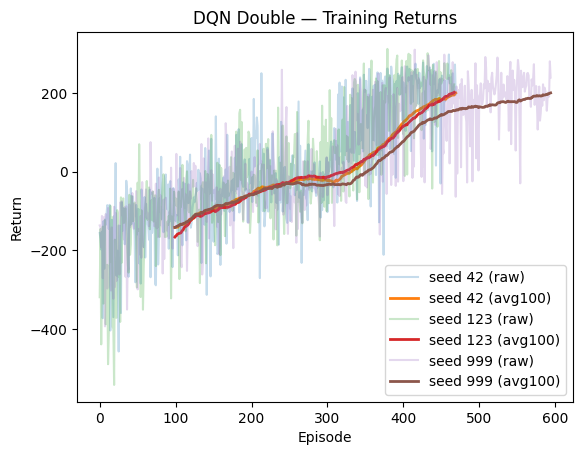

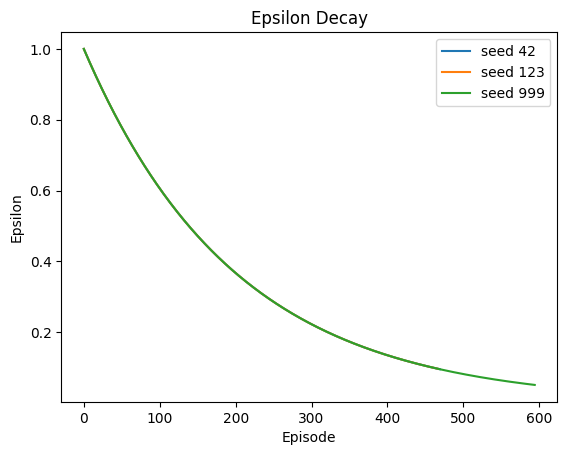

In [16]:
def load_curves(path):
    d = np.load(path, allow_pickle=True)
    return {
        "returns": d["returns"],
        "lengths": d["lengths"],
        "eps": d["eps"],
        "losses": d["losses"],
        "solved_at_episode": int(d["solved_at_episode"][0]),
        "total_steps": int(d["total_steps"][0]),
        "grad_updates": int(d["grad_updates"][0]),
    }

def moving_avg(x, w=100):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return np.full_like(x, np.nan, dtype=float)
    c = np.convolve(x, np.ones(w)/w, mode="valid")
    return np.concatenate([np.full(w-1, np.nan), c])

def plot_training(seed_to_path):
    plt.figure()
    for seed, path in seed_to_path.items():
        curves = load_curves(path)
        r = curves["returns"]
        plt.plot(r, alpha=0.25, label=f"seed {seed} (raw)")
        plt.plot(moving_avg(r, 100), linewidth=2, label=f"seed {seed} (avg100)")
    plt.title("DQN Double — Training Returns")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.show()

    plt.figure()
    for seed, path in seed_to_path.items():
        curves = load_curves(path)
        plt.plot(curves["eps"], label=f"seed {seed}")
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.legend()
    plt.show()

seed_to_path = {r["seed"]: r["curves_path"] for r in dqn_results}
plot_training(seed_to_path)

In [17]:
eval_means = np.array([r["eval_mean_20"] for r in dqn_results], dtype=float)
eval_stds  = np.array([r["eval_std_20"]  for r in dqn_results], dtype=float)

print("DQN (3 seeds) — Eval mean over seeds:", round(eval_means.mean(), 2),
      "±", round(eval_means.std(ddof=1), 2))
print("Per-seed eval means:", np.round(eval_means, 2))
print("Per-seed train steps:", [r["train_total_steps"] for r in dqn_results])
print("Per-seed grad updates:", [r["grad_updates"] for r in dqn_results])


DQN (3 seeds) — Eval mean over seeds: 181.07 ± 6.87
Per-seed eval means: [188.5  174.95 179.75]
Per-seed train steps: [240714, 239283, 320846]
Per-seed grad updates: [59679, 59321, 79712]


Best GIF seed: 123 | return: 276.1249378809255


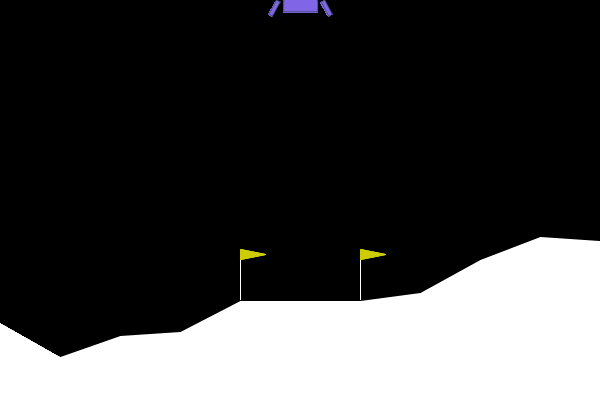

In [18]:
best = max([r for r in dqn_results if "center_gif_path" in r], key=lambda x: x.get("center_gif_return", -1))
print("Best GIF seed:", best["seed"], "| return:", best.get("center_gif_return"))
display(Image(filename=best["center_gif_path"]))



In [19]:
def landing_stats(model_path, n=50, seed=0):
    env = gym.make("LunarLander-v3")
    obs, _ = env.reset(seed=seed)

    net = Network(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path, map_location="cpu"))
    net.eval()

    inside = 0
    landed = 0
    crashed = 0

    for ep in range(n):
        s, _ = env.reset(seed=seed + ep)
        done = False

        for t in range(1000):
            with torch.no_grad():
                q = net(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
            a = int(torch.argmax(q, dim=1).item())

            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            if done:
                # heuristic: leg contacts (state[6], state[7]) == 1 suggests landing contact
                # and small speed suggests safe landing
                vx, vy = s[2], s[3]
                left, right = s[6], s[7]
                if (left > 0.5 or right > 0.5) and abs(vx) < 0.5 and abs(vy) < 0.5:
                    landed += 1
                    # “inside pad” proxy: x position near center (state[0] close to 0)
                    if abs(s[0]) < 0.2:
                        inside += 1
                else:
                    crashed += 1
                break

    env.close()
    return {"landed": landed, "crashed": crashed, "inside_proxy": inside, "n": n}

stats = landing_stats("runs_lunarlander/dqn_double_seed42.pth", n=50, seed=42)
stats


{'landed': 50, 'crashed': 0, 'inside_proxy': 28, 'n': 50}

# PPO 

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [21]:
# ====== PPO ======

def make_env(seed: int):
    env = gym.make(ENV_ID)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

# --- Actor-Critic Network (shared trunk) ---
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=256):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
        )
        self.pi = nn.Linear(hidden, act_dim)   # logits
        self.v  = nn.Linear(hidden, 1)         # value

    def forward(self, x):
        h = self.trunk(x)
        return self.pi(h), self.v(h)

def compute_gae(rewards, dones, values, last_value, gamma=0.99, lam=0.95):
    T = len(rewards)
    adv = np.zeros(T, dtype=np.float32)
    gae = 0.0
    for t in reversed(range(T)):
        next_v = last_value if t == T - 1 else values[t + 1]
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_v * nonterminal - values[t]
        gae = delta + gamma * lam * nonterminal * gae
        adv[t] = gae
    ret = adv + values
    return adv, ret

@torch.no_grad()
def ppo_eval(model, seed, n_episodes=100, max_steps=1000):
    env = make_env(seed + 10_000)
    rets = []
    lens = []

    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + 10_000 + ep)
        ep_ret = 0.0
        ep_len = 0
        for t in range(max_steps):
            x = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            logits, _ = model(x)
            a = int(torch.argmax(logits, dim=1).item())  # deterministic
            s, r, terminated, truncated, _ = env.step(a)
            ep_ret += float(r)
            ep_len += 1
            if terminated or truncated:
                break
        rets.append(ep_ret)
        lens.append(ep_len)

    env.close()
    return float(np.mean(rets)), float(np.std(rets, ddof=1)), rets, lens


def run_ppo(
    seed: int,
    total_steps_budget: int,          
    max_steps_per_ep: int = 1000,
    lr: float = 4e-4,
    gamma: float = 0.99,
    lam: float = 0.95,
    clip_eps: float = 0.2,
    ent_coef: float = 0.01,
    vf_coef: float = 0.5,
    max_grad_norm: float = 0.5,
    rollout_len: int = 2048,
    epochs: int = 10,
    batch_size: int = 128,
    eval_episodes: int = 20,
    make_gif: bool = True,
    gif_tries: int = 300,
    gif_center_tol: float = 0.2,
    gif_fps: int = 30,
):
    # reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = make_env(seed)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    model = ActorCritic(obs_dim, act_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # logs
    returns_ep = []
    lengths_ep = []
    total_steps = 0
    update_steps = 0

    while total_steps < total_steps_budget:
        # --- collect rollout ---
        obs_buf, act_buf, logp_buf, rew_buf, done_buf, val_buf = [], [], [], [], [], []

        s, _ = env.reset(seed=seed + total_steps)
        ep_ret = 0.0
        ep_len = 0

        for t in range(rollout_len):
            x = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            logits, v = model(x)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()
            logp = dist.log_prob(a)

            s2, r, terminated, truncated, _ = env.step(int(a.item()))
            done = terminated or truncated

            obs_buf.append(s)
            act_buf.append(int(a.item()))
            logp_buf.append(float(logp.item()))
            rew_buf.append(float(r))
            done_buf.append(float(done))
            val_buf.append(float(v.item()))

            ep_ret += float(r)
            ep_len += 1
            total_steps += 1

            s = s2

            if done or ep_len >= max_steps_per_ep:
                returns_ep.append(ep_ret)
                lengths_ep.append(ep_len)
                s, _ = env.reset(seed=seed + total_steps)
                ep_ret = 0.0
                ep_len = 0

            if total_steps >= total_steps_budget:
                break

        # bootstrap last value
        x = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
        _, last_v = model(x)
        last_v = float(last_v.item())

        adv, ret = compute_gae(
            rew_buf, done_buf, np.array(val_buf, dtype=np.float32), last_v, gamma=gamma, lam=lam
        )
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        # --- to tensors ---
        obs_t = torch.tensor(np.array(obs_buf), dtype=torch.float32, device=device)
        act_t = torch.tensor(np.array(act_buf), dtype=torch.int64, device=device)
        old_logp_t = torch.tensor(np.array(logp_buf), dtype=torch.float32, device=device)
        adv_t = torch.tensor(adv, dtype=torch.float32, device=device)
        ret_t = torch.tensor(ret, dtype=torch.float32, device=device)

        N = obs_t.shape[0]
        idx = np.arange(N)

        # --- PPO update ---
        for _ in range(epochs):
            np.random.shuffle(idx)
            for start in range(0, N, batch_size):
                mb = idx[start:start + batch_size]

                logits, v = model(obs_t[mb])
                dist = torch.distributions.Categorical(logits=logits)
                logp = dist.log_prob(act_t[mb])
                ratio = torch.exp(logp - old_logp_t[mb])

                surr1 = ratio * adv_t[mb]
                surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_t[mb]
                pi_loss = -torch.min(surr1, surr2).mean()

                v_loss = ((v.squeeze(-1) - ret_t[mb]) ** 2).mean()
                ent = dist.entropy().mean()

                loss = pi_loss + vf_coef * v_loss - ent_coef * ent

                opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                opt.step()

                update_steps += 1

        if len(returns_ep) and (len(returns_ep) % 50 == 0):
            avg50 = float(np.mean(returns_ep[-50:]))
            print(f"Seed {seed} | steps {total_steps}/{total_steps_budget} | avg(last50): {avg50:7.2f} | updates: {update_steps}")

    env.close()

    # eval
    mean_eval, std_eval, eval_rets, eval_lens = ppo_eval(
        model, seed=seed, n_episodes=eval_episodes, max_steps=max_steps_per_ep
    )

    # save
    model_path = os.path.join(OUT_DIR, f"ppo_seed{seed}.pth")
    torch.save(model.state_dict(), model_path)

    curves_path = os.path.join(OUT_DIR, f"ppo_curves_seed{seed}.npz")
    np.savez(
        curves_path,
        returns=np.array(returns_ep, dtype=float),
        lengths=np.array(lengths_ep, dtype=int),
        total_steps=np.array([total_steps], dtype=int),
        grad_updates=np.array([update_steps], dtype=int),
    )

    results = {
        "seed": seed,
        "train_total_steps": total_steps,
        "grad_updates": update_steps,
        "eval_mean_20": mean_eval,
        "eval_std_20": std_eval,
        "model_path": model_path,
        "curves_path": curves_path,
    }

    print("Saved model:", model_path)
    print("Saved curves:", curves_path)
    print(f"PPO Eval (20 eps) mean±std: {mean_eval:.2f} ± {std_eval:.2f}")
    print("Gradient updates:", update_steps)

    # ---------- GIF (centered landing) ----------
    if make_gif:
        import imageio
        import gymnasium as gym

        def policy_act_from_model(model, obs):
            x = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            logits, _ = model(x)
            return int(torch.argmax(logits, dim=1).item())  # deterministic

        def _find_center_seed_ppo(model, base_seed, tries=300, center_tol=0.2):
            env_tmp = gym.make(ENV_ID)
            for i in range(tries):
                obs, _ = env_tmp.reset(seed=base_seed + i)
                for _ in range(max_steps_per_ep):
                    a = policy_act_from_model(model, obs)
                    obs, r, terminated, truncated, _ = env_tmp.step(a)
                    if terminated or truncated:
                        x = float(obs[0])
                        vx, vy = float(obs[2]), float(obs[3])
                        left, right = float(obs[6]), float(obs[7])
                        landed = (left > 0.5 or right > 0.5) and abs(vx) < 0.5 and abs(vy) < 0.5
                        if landed and abs(x) < center_tol:
                            env_tmp.close()
                            return base_seed + i
                        break
            env_tmp.close()
            return None

        def _save_gif_ppo(model, seed_gif, gif_path, fps=30):
            env_gif = gym.make(ENV_ID, render_mode="rgb_array")
            obs, _ = env_gif.reset(seed=seed_gif)

            frames = []
            total_r = 0.0

            for _ in range(max_steps_per_ep):
                frames.append(env_gif.render())
                a = policy_act_from_model(model, obs)
                obs, r, terminated, truncated, _ = env_gif.step(a)
                total_r += float(r)
                if terminated or truncated:
                    frames.append(env_gif.render())
                    break

            env_gif.close()
            imageio.mimsave(gif_path, frames, fps=fps)
            return total_r

        good_seed = _find_center_seed_ppo(
            model, base_seed=seed + 1000, tries=gif_tries, center_tol=gif_center_tol
        )

        if good_seed is not None:
            gif_path = os.path.join(OUT_DIR, f"ppo_center_seed{seed}.gif")
            gif_return = _save_gif_ppo(model, seed_gif=good_seed, gif_path=gif_path, fps=gif_fps)
            results["center_gif_path"] = gif_path
            results["center_gif_seed"] = int(good_seed)
            results["center_gif_return"] = float(gif_return)
            print("Saved centered GIF:", gif_path, "| seed:", good_seed, "| return:", round(gif_return, 2))
        else:
            print("No centered landing episode found (increase gif_tries or relax gif_center_tol).")

    return results


In [22]:
BUDGET = 300_000
seeds = [42, 123, 999]
ppo_results = [run_ppo(s, total_steps_budget=BUDGET) for s in seeds]
ppo_results


Seed 42 | steps 188416/300000 | avg(last50):  174.78 | updates: 14720
Seed 42 | steps 215040/300000 | avg(last50):  190.72 | updates: 16800
Saved model: runs_lunarlander/ppo_seed42.pth
Saved curves: runs_lunarlander/ppo_curves_seed42.npz
PPO Eval (20 eps) mean±std: 98.18 ± 172.24
Gradient updates: 23440
Saved centered GIF: runs_lunarlander/ppo_center_seed42.gif | seed: 1046 | return: 258.04
Seed 123 | steps 14336/300000 | avg(last50): -344.44 | updates: 1120
Seed 123 | steps 43008/300000 | avg(last50):  -82.09 | updates: 3360
Seed 123 | steps 280576/300000 | avg(last50):  229.22 | updates: 21920
Seed 123 | steps 292864/300000 | avg(last50):  226.71 | updates: 22880
Saved model: runs_lunarlander/ppo_seed123.pth
Saved curves: runs_lunarlander/ppo_curves_seed123.npz
PPO Eval (20 eps) mean±std: -22.85 ± 22.45
Gradient updates: 23440
Saved centered GIF: runs_lunarlander/ppo_center_seed123.gif | seed: 1241 | return: 172.1
Seed 999 | steps 47104/300000 | avg(last50):  -62.89 | updates: 3680
S

[{'seed': 42,
  'train_total_steps': 300000,
  'grad_updates': 23440,
  'eval_mean_20': 98.17583041496194,
  'eval_std_20': 172.23560806459938,
  'model_path': 'runs_lunarlander/ppo_seed42.pth',
  'curves_path': 'runs_lunarlander/ppo_curves_seed42.npz',
  'center_gif_path': 'runs_lunarlander/ppo_center_seed42.gif',
  'center_gif_seed': 1046,
  'center_gif_return': 258.03644565494403},
 {'seed': 123,
  'train_total_steps': 300000,
  'grad_updates': 23440,
  'eval_mean_20': -22.849028515024877,
  'eval_std_20': 22.449101785921357,
  'model_path': 'runs_lunarlander/ppo_seed123.pth',
  'curves_path': 'runs_lunarlander/ppo_curves_seed123.npz',
  'center_gif_path': 'runs_lunarlander/ppo_center_seed123.gif',
  'center_gif_seed': 1241,
  'center_gif_return': 172.10270116669767},
 {'seed': 999,
  'train_total_steps': 300000,
  'grad_updates': 23440,
  'eval_mean_20': 242.66493248298087,
  'eval_std_20': 20.86879686804199,
  'model_path': 'runs_lunarlander/ppo_seed999.pth',
  'curves_path': 'run

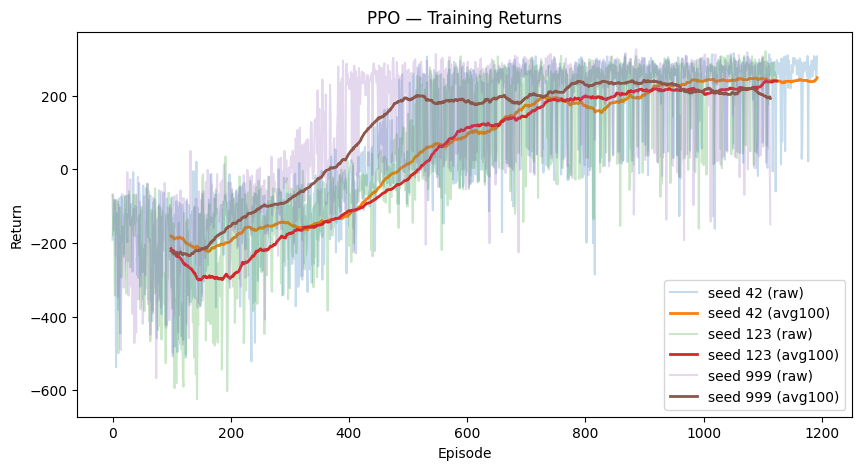

In [23]:
# ====== PPO: Training plots  ======

def load_ppo_curves(path):
    d = np.load(path, allow_pickle=True)
    # expected keys: returns, lengths, losses(optional), entropy(optional), total_steps, grad_updates
    out = {k: d[k] for k in d.files}
    return out

def moving_avg(x, w=100):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return np.full_like(x, np.nan, dtype=float)
    c = np.convolve(x, np.ones(w)/w, mode="valid")
    return np.concatenate([np.full(w-1, np.nan), c])

def plot_ppo_training(seed_to_path, avg_window=100):
    plt.figure(figsize=(10,5))
    for seed, path in seed_to_path.items():
        curves = load_ppo_curves(path)
        r = curves["returns"]
        plt.plot(r, alpha=0.25, label=f"seed {seed} (raw)")
        plt.plot(moving_avg(r, avg_window), linewidth=2, label=f"seed {seed} (avg{avg_window})")
    plt.title("PPO — Training Returns")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.show()

# build dict and plot
ppo_seed_to_path = {r["seed"]: r["curves_path"] for r in ppo_results}
plot_ppo_training(ppo_seed_to_path, avg_window=100)


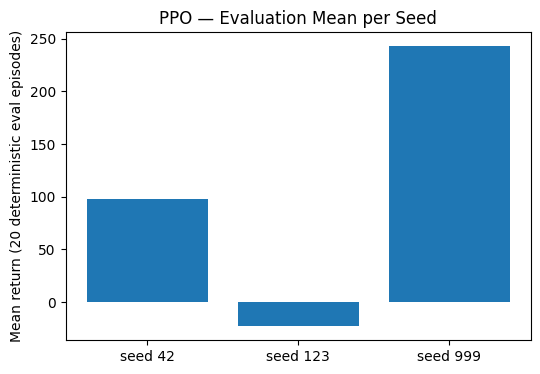

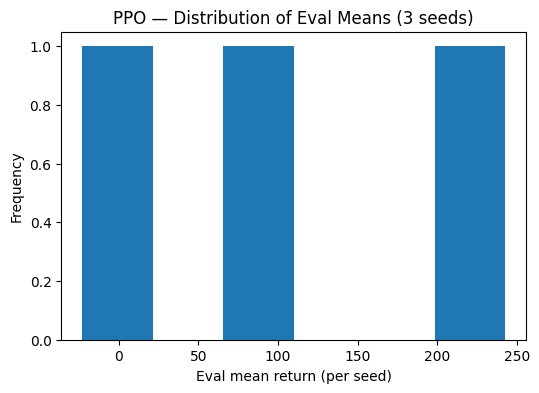

In [24]:
# ====== PPO: Evaluation plots (boxplot + distribution) ======

# If you saved eval returns inside the npz, use them; otherwise we only plot eval_mean_20 per seed.
eval_means = np.array([r["eval_mean_20"] for r in ppo_results], dtype=float)

plt.figure(figsize=(6,4))
plt.bar([f"seed {r['seed']}" for r in ppo_results], eval_means)
plt.ylabel("Mean return (20 deterministic eval episodes)")
plt.title("PPO — Evaluation Mean per Seed")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(eval_means, bins=6)
plt.xlabel("Eval mean return (per seed)")
plt.ylabel("Frequency")
plt.title("PPO — Distribution of Eval Means (3 seeds)")
plt.show()


In [25]:
import os
os.makedirs(OUT_DIR, exist_ok=True)

res = run_ppo(seed=42, total_steps_budget=300_000, make_gif=True)
res


Seed 42 | steps 188416/300000 | avg(last50):  174.78 | updates: 14720
Seed 42 | steps 215040/300000 | avg(last50):  190.72 | updates: 16800
Saved model: runs_lunarlander/ppo_seed42.pth
Saved curves: runs_lunarlander/ppo_curves_seed42.npz
PPO Eval (20 eps) mean±std: 98.18 ± 172.24
Gradient updates: 23440
Saved centered GIF: runs_lunarlander/ppo_center_seed42.gif | seed: 1046 | return: 258.04


{'seed': 42,
 'train_total_steps': 300000,
 'grad_updates': 23440,
 'eval_mean_20': 98.17583041496194,
 'eval_std_20': 172.23560806459938,
 'model_path': 'runs_lunarlander/ppo_seed42.pth',
 'curves_path': 'runs_lunarlander/ppo_curves_seed42.npz',
 'center_gif_path': 'runs_lunarlander/ppo_center_seed42.gif',
 'center_gif_seed': 1046,
 'center_gif_return': 258.03644565494403}

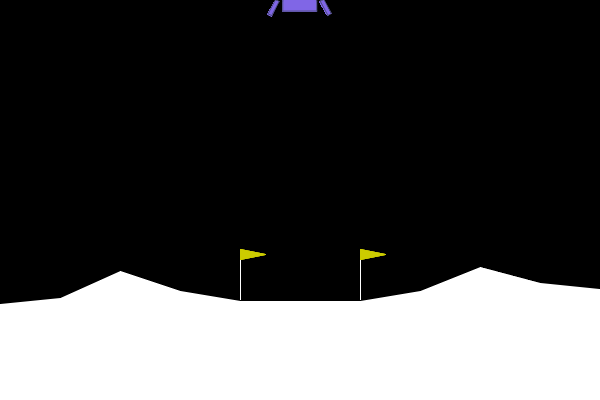

In [26]:
from IPython.display import Image, display
display(Image(filename=res["center_gif_path"]))
